# The Oguri Model

NOTE: Remember to clean up code and add comments / reference resources before submission

In this notebook, we will ...

**Learning Objectives**

1. ...

**Import modules**
Begin by importing the modules to be used in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dateutil import parser
import matplotlib.colors as mpl_colors
from sklearn.model_selection import train_test_split

## Japanese Race Horses

Let's read in the data here:

In [2]:
# read in the Japanese Race Horse racing data
df_jp = pd.read_csv('jpracehorses.csv', header=1)

df_jp.head()

,NAME,DATE,RACENAME,COURSE,TRACK,DISTANCE,CONDITION,FINISHTIME,FINISHPOSITION,MARGIN,WEIGHT,SEX
0,Special Week,"Dec 26,1999",ARIMA KINEN (GRAND PRIX) G1,NAKAYAMA,TURF,2500M,FIRM,2:37.2,2,0.0,464 (-4),Stallion
1,Special Week,"Nov 28,1999",JAPAN CUP G1,TOKYO,TURF,2400M,FIRM,2:25.5,1,0.2,468 (-2),Stallion
2,Special Week,"Oct 31,1999",TENNO SHO(AUTUMN) G1,TOKYO,TURF,2000M,FIRM,1:58.0,1,0.1,470 (-16),Stallion
3,Special Week,"Oct 10,1999",KYOTO DAISHOTEN G2,KYOTO,TURF,2400M,FIRM,2:25.1,7,0.8,486 (+6),Stallion
4,Special Week,"Jul 11,1999",TAKARAZUKA KINEN G1,HANSHIN,TURF,2200M,FIRM,2:12.6,2,0.5,480 (+4),Stallion


In [3]:
# https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
# https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.strftime.html
# Data Preprocessing
# Converts string date to datetime format, then converts to Year-Month-Date format
df_jp['DATE'] = pd.to_datetime(df_jp['DATE'], format="%b %d,%Y", errors='coerce')
df_jp['DATE'] = df_jp['DATE'].dt.strftime('%Y-%m-%d')
df_jp['DISTANCE'] = df_jp['DISTANCE'].astype(str).str.replace('M', '')
df_jp['DISTANCE'] = pd.to_numeric(df_jp['DISTANCE'],errors='coerce')
df_jp['FINISHPOSITION'] = pd.to_numeric(df_jp['FINISHPOSITION'],errors='coerce')
#TODO: Convert finish time into all seconds, and to convert from string into float
def convert_time_jp(time):
    # TODO: check for inv. values if needed
    try:
        # for the cases of NaN (some races don't have finish times)
        if pd.isna(time):
            return np.nan
        parts = str(time).split(':')
        if len(parts) == 2:
            # for the cases (ex. 1:30.1)
            mins, secs = int(parts[0]), float(parts[1])
            res = (mins * 60) + secs
        elif len(parts) == 1:
            # for the cases (ex. 95.1)
            res = float(parts[0])
        else:
            return np.nan
        #mins, secs = int(parts[0]), float(parts[1])
        #res = (mins * 60) + secs
    except Exception as e:
        return np.nan
    return res

df_jp['FINISHTIME'] = df_jp['FINISHTIME'].apply(convert_time_jp)
df_jp['MARGIN'] = pd.to_numeric(df_jp['MARGIN'],errors='coerce')
df_jp['WEIGHT'] = df_jp['WEIGHT'].astype(str).str.extract(r'(\d+)').astype(float)

# Converting CONDITIONS to numerical values
conditions_map = {
    # Rank 1 (Fastest, Firmest)
    'FIRM': 1, 'FAST': 1, 'GOOD TO FIRM': 1, 'WF': 1,
    # Rank 2 (Good, Standard)
    'GOOD': 2, 'GD': 2, 'STANDARD': 2,
    # Rank 3 (Slightly Slow, Yielding)
    'YIELD': 3, 'YIELDING': 3, 'GOOD TO YIELDING': 3, 'SLOW': 3, 'WS': 3,
    # Rank 4 (Slowest, Heavy, Adverse)
    'SOFT': 4, 'HEAVY': 4, 'MUDDY': 4, 'SLOPPY': 4, 'POOR': 4, 'SE': 4, 'SLOPPY': 4
}

#unique_names = df_jp['CONDITION'].unique()
#print(unique_names)
df_jp['CONDITION_CLASSIFICATION'] = 0 # TODO: need to add a condition where 0 is invalid or dropped because it corresponds to NaN conditions
df_jp['CONDITION_CLASSIFICATION'] = df_jp['CONDITION'].map(conditions_map).astype(float)

# add a classification column for SEX
sex_map = {'Stallion': 1, 'Mare': 0, 'Gelding': 0}
df_jp['SEX_CLASSIFICATION'] = 1
df_jp['SEX_CLASSIFICATION'] = df_jp['SEX'].map(sex_map).astype(float)

# add a classification column for TRACK
#unique_track = df_jp['TRACK'].unique()
#print(unique_track)
track_map = {
    'TURF': 1, 
    'Turf': 1,
    'AWT': 0, 
    'DIRT': 0,
    'Dirt': 0,
    'JUMP': 0
}
df_jp['TRACK_CLASSIFICATION'] = 1
df_jp['TRACK_CLASSIFICATION'] = df_jp['TRACK'].map(track_map).astype(float)
# get rid of any entry with a NaN value (some horses data could not be fully accessed so they were added with missing race data)
df_jp = df_jp.dropna()

In [4]:
pd.set_option('display.max_rows', None) # this is required to see all of the rows in the dataset.
#display(df_jp)
df_jp.head()
#df_jp.groupby('NAME')['MARGIN'].mean().sort_values(ascending=False)

,NAME,DATE,RACENAME,COURSE,TRACK,DISTANCE,CONDITION,FINISHTIME,FINISHPOSITION,MARGIN,WEIGHT,SEX,CONDITION_CLASSIFICATION,SEX_CLASSIFICATION,TRACK_CLASSIFICATION
0,Special Week,1999-12-26,ARIMA KINEN (GRAND PRIX) G1,NAKAYAMA,TURF,2500.0,FIRM,157.2,2.0,0.0,464.0,Stallion,1.0,1.0,1.0
1,Special Week,1999-11-28,JAPAN CUP G1,TOKYO,TURF,2400.0,FIRM,145.5,1.0,0.2,468.0,Stallion,1.0,1.0,1.0
2,Special Week,1999-10-31,TENNO SHO(AUTUMN) G1,TOKYO,TURF,2000.0,FIRM,118.0,1.0,0.1,470.0,Stallion,1.0,1.0,1.0
3,Special Week,1999-10-10,KYOTO DAISHOTEN G2,KYOTO,TURF,2400.0,FIRM,145.1,7.0,0.8,486.0,Stallion,1.0,1.0,1.0
4,Special Week,1999-07-11,TAKARAZUKA KINEN G1,HANSHIN,TURF,2200.0,FIRM,132.6,2.0,0.5,480.0,Stallion,1.0,1.0,1.0


## Hong Kong Race Horses

Let's read in the data here:

In [5]:
# read in the Japanese Race Horse racing data
df_hk = pd.read_csv('hkracehorses.csv', header=1)

df_hk.head()

,NAME,DATE,RACENAME,COURSE,TRACK,DISTANCE,CONDITION,FINISHTIME,FINISHPOSITION,MARGIN,WEIGHT,SEX
0,AURORA LADY (J066),11/02/25,149,HAPPY VALLEY,Turf,1200,GOOD TO FIRM,1.09.09,3,1-1/4,124,Stallion
1,AURORA LADY (J066),"Oct 22,2025",119,HAPPY VALLEY,Turf,1000,GOOD,0.56.82,4,3-3/4,130,Stallion
2,AURORA LADY (J066),"Jul 16,2025",846,HAPPY VALLEY,Turf,1200,GOOD TO FIRM,1.08.65,3,3-1/2,119,Stallion
3,AURORA LADY (J066),"Jun 28,2025",794,SHA TIN,Turf,1000,GOOD,0.56.56,6,5-1/2,120,Stallion
4,AURORA LADY (J066),06/04/25,736,HAPPY VALLEY,Turf,1200,GOOD TO YIELDING,1.10.07,6,2-1/2,129,Stallion


In [6]:
df_hk['NAME'] = df_hk['NAME'].str.replace(r'\s*\([^)]*\)', '', regex=True)
# Parser changes all of the date entries to be in the same format, and strftime changes it into year-month-day format
# HK dataset recorded dates in different formats, so could not be cleaned the same way as JP set.
# https://stackoverflow.com/questions/48384376/converting-multiple-date-formats-into-one-format-python
df_hk['DATE'] = df_hk['DATE'].astype(str).map(parser.parse)
df_hk['DATE'] = df_hk['DATE'].dt.strftime('%Y-%m-%d')
df_hk['DISTANCE'] = pd.to_numeric(df_hk['DISTANCE'],errors='coerce').astype(float)
df_hk['FINISHPOSITION'] = pd.to_numeric(df_hk['FINISHPOSITION'],errors='coerce')

def convert_time_hk(time):
    # TODO: check for inv. values if needed
    try:
        parts = str(time).split('.')
        #if len(parts) != 3:
        #    return np.nan
        #mins, secs, centisecs, = int(parts[0]), int(parts[1]), int(parts[2])
        #res = (mins * 60) + secs + (centisecs / 100.0)
        if len(parts) == 3:
            # for the cases of finish times (ex. 1.09.09)
            mins, secs, centisecs, = int(parts[0]), int(parts[1]), int(parts[2])
            res = (mins * 60) + secs + (centisecs / 100.0)
        elif len(parts) == 2:
            # for the cases of finish times (ex. 58.3)
            res = float(parts[0]) + (float(parts[1]) / 100.0)
        else:
            return np.nan
    except ValueError as e:
        print(f"Invalid value '{time}'")
        return np.nan
    return res

def convert_margin_hk(margin):
    # TODO: check for inv. values if needed
    try:
        margin = str(margin)
        if '-' in margin:
            whole, frac = margin.split('-')
            # invalid val
            if '/' not in frac:
                return np.nan
            whole = float(whole)
            num, den = map(int, frac.split('/'))
            return whole + (float(num) / den)
        elif '/' in margin:
            num, den = map(int, margin.split('/'))
            #return whole + (float(num) / den)
            return float(num) / den
        else:
            return float(margin)
    except Exception as e:
        return np.nan

df_hk['FINISHTIME'] = df_hk['FINISHTIME'].apply(convert_time_hk)
df_hk['MARGIN'] = df_hk['MARGIN'].apply(convert_margin_hk)
df_hk['WEIGHT'] = pd.to_numeric(df_hk['WEIGHT'],errors='coerce').astype(float)

#unique_names = df_hk['CONDITION'].unique()
#print(unique_names)
df_hk['CONDITION_CLASSIFICATION'] = 0 # TODO: need to add a condition where 0 is invalid or dropped because it corresponds to NaN conditions
df_hk['CONDITION_CLASSIFICATION'] = df_hk['CONDITION'].map(conditions_map).astype(float)

# add a classification column for SEX
df_hk['SEX_CLASSIFICATION'] = 1
df_hk['SEX_CLASSIFICATION'] = df_hk['SEX'].map(sex_map).astype(float)

#unique_track = df_hk['TRACK'].unique()
#print(unique_track)
# add a classification column for TRACK
df_hk['TRACK_CLASSIFICATION'] = 1
df_hk['TRACK_CLASSIFICATION'] = df_hk['TRACK'].map(track_map).astype(float)

# get rid of any entry with a NaN value (some horses data could not be fully accessed so they were added with missing race data)
df_hk = df_hk.dropna()

In [7]:
df_hk.head()

,NAME,DATE,RACENAME,COURSE,TRACK,DISTANCE,CONDITION,FINISHTIME,FINISHPOSITION,MARGIN,WEIGHT,SEX,CONDITION_CLASSIFICATION,SEX_CLASSIFICATION,TRACK_CLASSIFICATION
0,AURORA LADY,2025-11-02,149,HAPPY VALLEY,Turf,1200.0,GOOD TO FIRM,69.09,3.0,1.25,124.0,Stallion,1.0,1.0,1.0
1,AURORA LADY,2025-10-22,119,HAPPY VALLEY,Turf,1000.0,GOOD,56.82,4.0,3.75,130.0,Stallion,2.0,1.0,1.0
2,AURORA LADY,2025-07-16,846,HAPPY VALLEY,Turf,1200.0,GOOD TO FIRM,68.65,3.0,3.50,119.0,Stallion,1.0,1.0,1.0
3,AURORA LADY,2025-06-28,794,SHA TIN,Turf,1000.0,GOOD,56.56,6.0,5.50,120.0,Stallion,2.0,1.0,1.0
4,AURORA LADY,2025-06-04,736,HAPPY VALLEY,Turf,1200.0,GOOD TO YIELDING,70.07,6.0,2.50,129.0,Stallion,3.0,1.0,1.0


In [8]:
#pd.set_option('display.max_rows', None) # this is required to see all of the rows in the dataset.
#display(df_hk)
#df_hk.head()
#df_hk.groupby('NAME')['FINISHPOSITION'].mean().sort_values(ascending=False)


## Japanese Horses Raw Data Plot

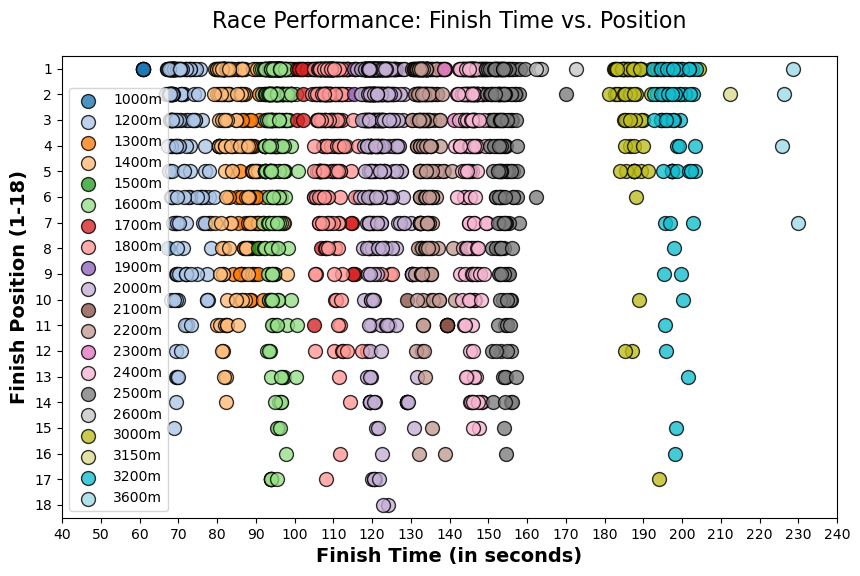

In [9]:
jp_distances = [1000, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 3000, 3150, 3200, 3600]
jp_xticks = [40, 250, 10]

# Code for raw data plot
def raw_data_plot(distances, df, xticks_vars):
    plt.figure(figsize=(10, 6))
    cmap_base = plt.colormaps.get_cmap('tab20')

    colors = cmap_base(np.linspace(0, 1, len(distances)))

    for i, distance in enumerate(distances):
        df_subset = df[df['DISTANCE'] == distance]

        if not df_subset.empty:
            plt.scatter(df_subset['FINISHTIME'], df_subset['FINISHPOSITION'],
                        c=[colors[i]],
                        edgecolor='black',     # Black border for clarity
                        s=100,                 # Marker size
                        alpha=0.8,             # Transparency
                        label=f'{distance}m')
    plt.legend()
    
    plt.xlabel('Finish Time (in seconds)', fontsize=14, fontweight='bold')
    plt.ylabel('Finish Position (1-18)', fontsize=14, fontweight='bold')
    plt.title('Race Performance: Finish Time vs. Position', fontsize=16, pad=20)
    plt.gca().invert_yaxis()
    plt.ylim(18.5, 0.5)
    xticks = plt.xticks(list(range(xticks_vars[0], xticks_vars[1], xticks_vars[2])))
    yticks = plt.yticks(list(range(1, 19)))

raw_data_plot(jp_distances, df_jp, jp_xticks)

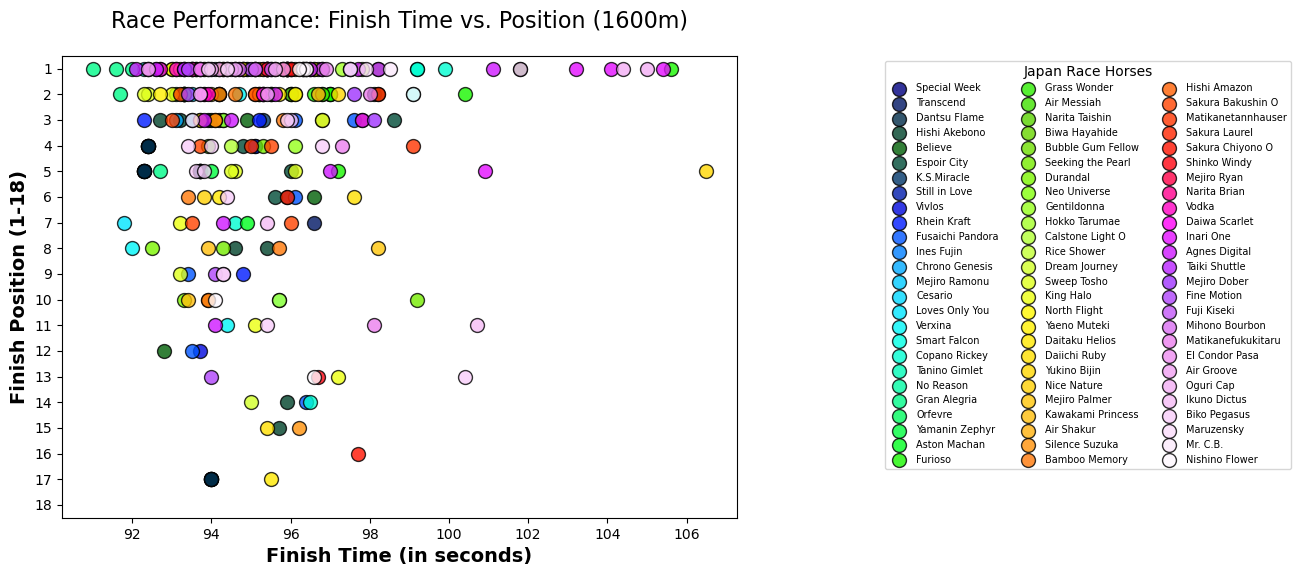

In [10]:
# Code for raw data plot for just distance = 1600
jp_1600_df = df_jp[df_jp['DISTANCE'] == 1600]

def filtered_raw_data_plot(df, df_type):
    unique_horses = df['NAME'].unique()
    num_horses = len(unique_horses)
    
    cmap_base = plt.colormaps.get_cmap('gist_ncar')
    colors = cmap_base(np.linspace(0, 1, num_horses))
    
    plt.figure(figsize=(10, 6))
    for i, horse_name in enumerate(unique_horses):
            df_subset = df[df['NAME'] == horse_name]

            color_index = i % len(colors)

            if not df_subset.empty:
                plt.scatter(df_subset['FINISHTIME'], df_subset['FINISHPOSITION'],
                            c=[colors[color_index]],
                            edgecolor='black',     
                            s=100,               
                            alpha=0.8,           
                            label=horse_name)

    # bbox_to_anchor controls the position of the legend (necessary to get it outside of the plot)
    plt.legend(title=f'{df_type} Race Horses',ncol=3, fontsize=7, bbox_to_anchor=(1.52, 1), loc='upper center')
    # https://www.geeksforgeeks.org/python/matplotlib-pyplot-subplots_adjust-in-python/
    # used to adjust the spacing of the subplots (necessary since the legend is outside of the plot)
    plt.subplots_adjust(right=0.80)
    # color code for individual horses? @andrei
    
    plt.xlabel('Finish Time (in seconds)', fontsize=14, fontweight='bold')
    plt.ylabel('Finish Position (1-18)', fontsize=14, fontweight='bold')
    plt.title('Race Performance: Finish Time vs. Position (1600m)', fontsize=16, pad=20)
    plt.gca().invert_yaxis()
    plt.ylim(18.5, 0.5)
    yticks = plt.yticks(list(range(1, 19)))
    plt.show()


filtered_raw_data_plot(jp_1600_df, 'Japan')

## Hong Kong Horses Raw Data Plot

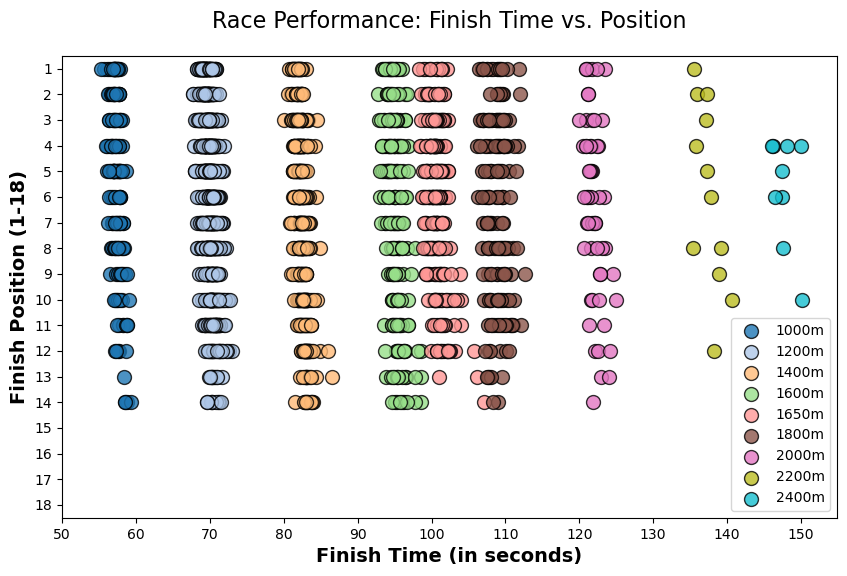

In [11]:
hk_distances = [1000, 1200, 1400, 1600, 1650, 1777, 1800, 2000, 2070, 2200, 2400, 2410]
hk_xticks = [50, 160, 10]

raw_data_plot(hk_distances, df_hk, hk_xticks)

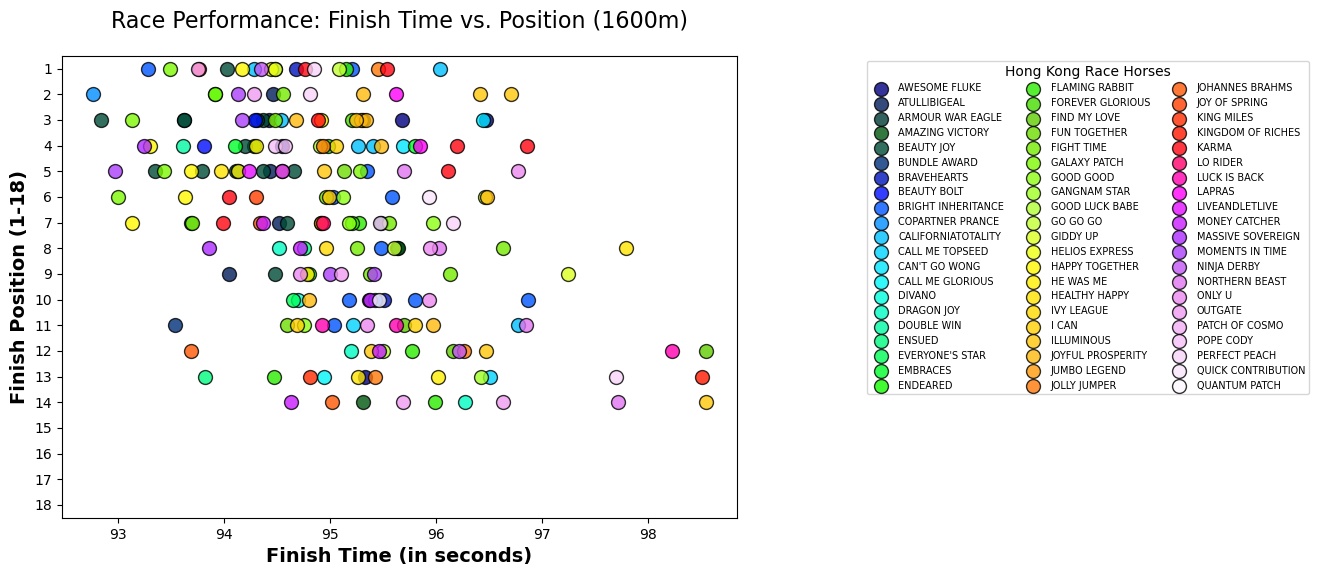

In [12]:
hk_1600_df = df_hk[df_hk['DISTANCE'] == 1600]

filtered_raw_data_plot(hk_1600_df, 'Hong Kong')

Before creating the models, we need to combine the Japan Race Horse and Hong Kong Race Horse data into one dataframe.

In [13]:
# Before combining, we need to go back and assign a 'label' to each JP and HK
# horse to identify them in the combined dataframe
df_jp['REGION'] = 1
df_hk['REGION'] = 0

# Combine the datasets
df_combined = pd.concat([df_jp, df_hk], ignore_index=True)
#display(df_combined)


## Mini Model 1: Predicting Finish Time 

In [14]:
class LinearRegression:
    """
    Linear regression model for predicting continuous outputs.
    """

    def __init__(self, X, learning_rate, n_iterations, random_seed=1):
        """
        Initializes the LinearRegression model and its parameters.

        Parameters
        ----------
        X : np.ndarray
            Input feature matrix used to determine the number of weights.
        learning_rate : float
            Learning rate for gradient descent.
        n_iterations : int
            Number of iterations for training.
        random_seed : int, optional
            Random seed for reproducibility (default is 1).
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.random_seed = random_seed
        self.initialize(X)
        

    def initialize(self, X):
        """
        Initializes the weight vector with small random values.
        """
        np.random.seed(self.random_seed)
        self.w = np.random.normal(loc=0.0, scale=0.01, size=np.shape(X)[1])
    
    def forward(self, X):
        """
        Computes the predicted output using the current weights.
        """
        y_hat = X@self.w
        return(y_hat)
        

    def loss(self, y, y_hat):
        """
        Computes the mean sum of squared errors loss.
        """
        return (1/np.size(y)) * np.sum((y-y_hat)**2)

    def loss_gradient(self, X, y, y_hat):
        """
        Computes the gradient of the loss with respect to weights.
        """
        return (-2/np.size(y)) * (y-y_hat).T @ X

    def fit(self, X, y):
        """
        Trains the linear regression model using gradient descent.
        """
        self.losses = []
        for iteration in range(self.n_iterations):
            y_hat = self.forward(X)
            gradient = self.loss_gradient(X, y, y_hat)
            self.w -= gradient*self.learning_rate
            self.losses.append(self.loss(y, y_hat))

In [23]:
# Input features: 
# DISTANCE (meters/float value) 
# TRACK (dirt/turf, binary value, need to assign like male/female example in lecture) 
# SEX (stallion/hare, binary value, need to assign like male/female)
# WEIGHT (float)
# CONDITION

def mini_model_1_multiple_linear_regression(df):
    
    feature_variables = ['DISTANCE', 'TRACK_CLASSIFICATION', 'SEX_CLASSIFICATION', 'WEIGHT', 'CONDITION_CLASSIFICATION', 'REGION']
    
    X = df[feature_variables] # independent variables used to predict dependent variable
    y = df['FINISHTIME'] # dependent variable

    # split our data into a training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17) # exactly from Lecture 6-1

    # Store the mean and std
    X_train_means = X_train.mean()
    X_train_stds = X_train.std() 
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()

    # standardize the features
    X_train_standardized = (X_train - X_train.mean()) / X_train.std()
    X_test_standardized = (X_test - X_train.mean()) / X_train.std()
    y_train_standardized = (y_train - y_train.mean()) / y_train.std()

    X_train_standardized = X_train_standardized.values
    X_test_standardized = X_test_standardized.values
    y_train_standardized = y_train_standardized.values

    # create and train multiple linear regression model
    model = LinearRegression(X_train_standardized, learning_rate=0.01, n_iterations=500)
    model.fit(X_train_standardized, y_train_standardized)

    plot_mini_model_1_losses(model)
    
    # make predictions
    y_train_pred = model.forward(X_train_standardized)
    y_test_pred = model.forward(X_test_standardized)

    # evaluate model
    train_mse = np.mean((y_train.values - y_train_pred)**2)
    test_mse = np.mean((y_test.values - y_test_pred)**2)
    print(f'Training MSE: {train_mse:.2f}')
    print(f'Test MSE: {test_mse:.2f}')
    # Use RMSE instead to account for the high MSE (I believe it happens due to high variation in finish times
    # (short + long distance races are included, which have drastically different finish times)
    # https://stats.stackexchange.com/questions/48267/mean-absolute-error-or-root-mean-squared-error
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    print(f'Training RMSE: {train_rmse:.2f}')
    print(f'Test RMSE: {test_rmse:.2f}')

    # convert the standardized weights back to the original scale
    y_train_pred = y_train_pred * y_train.std() + y_train.mean()
    y_test_pred = y_test_pred * y_train.std() + y_train.mean()

    # from lecture 3-1
    # # convert the standardized weights back to the original scale
    # w1 = w_1_standardized * np.std(y) / np.std(x)
    # w2 = w_2_standardized * np.std(y) / np.std(x**2)
    original_coefs = {}
    for i, feature in enumerate(feature_variables):
        original_coefs[feature] = model.w[i] * (y_train.std() / X_train_stds[feature])
    
    original_intercept = y_train_mean
    for i, feature in enumerate(feature_variables):
        original_intercept -= original_coefs[feature] * X_train_means[feature]

    for feature, coef in original_coefs.items():
        print(f'{feature:30s}: {coef:.6f}')

        plt.figure(figsize=(12, 4))

    # Visualize the results
    plt.subplot(1, 2, 1)
    plt.scatter(y_test.values, y_test_pred, alpha=0.5, edgecolors='k', linewidth=0.5)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Finish Time (seconds)')
    plt.ylabel('Predicted Finish Time (seconds)')
    plt.title('Predicted vs Actual')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    residuals = y_test.values - y_test_pred
    plt.scatter(y_test_pred, residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted Finish Time (seconds)')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    #print(X_test.index)

    return {
        'model': model,
        'y_test_pred': y_test_pred,
        'X_test': X_test,
        'X_test_indices': X_test.index,
        'test_mse': test_mse
    }


def plot_mini_model_1_losses(model):
    plt.figure(figsize=(8, 4))
    plt.plot(model.losses)
    plt.xlabel('Iterations')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss During Training')
    plt.grid(True, alpha=0.3)
    plt.show()


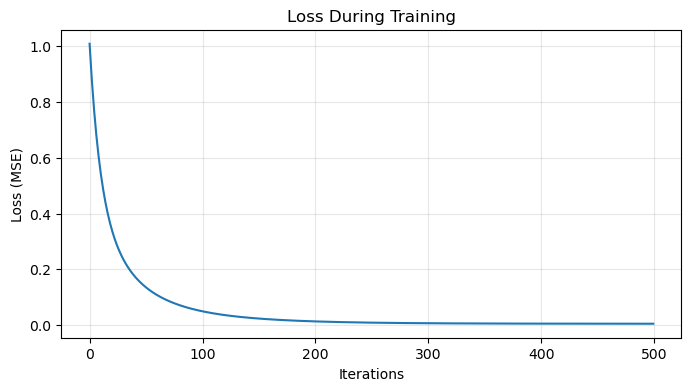

Training MSE: 11222.93
Test MSE: 11366.60
Training RMSE: 105.94
Test RMSE: 106.61
DISTANCE                      : 0.064048
TRACK_CLASSIFICATION          : -4.118124
SEX_CLASSIFICATION            : -0.414324
WEIGHT                        : 0.000255
CONDITION_CLASSIFICATION      : 0.863192
REGION                        : 0.249843


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

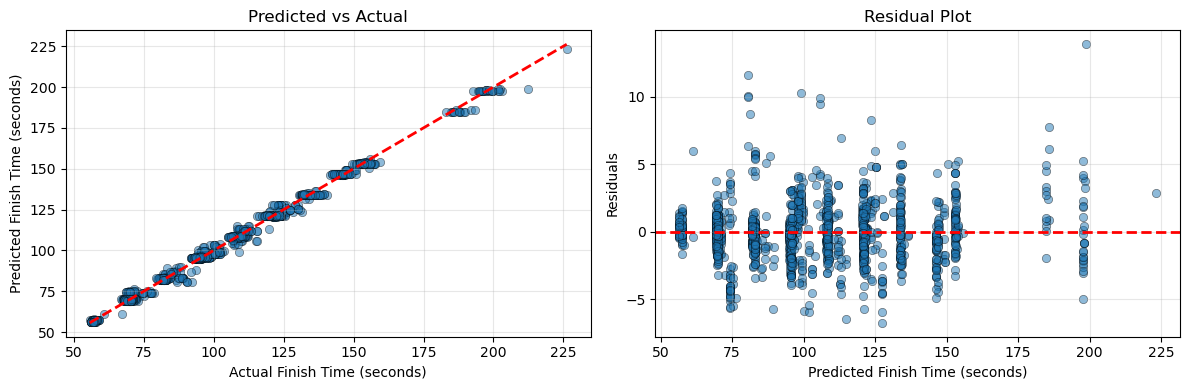

In [21]:
results1 = mini_model_1_multiple_linear_regression(df_combined)

## Mini Model 2: Predicting Margin

In [28]:
# Input features
# PREDICTED FINISH TIME (value from mini model 1)
# DISTANCE (meters/float value)
# SEX (binary)
# WEIGHT (float)

def mini_model_2_multiple_linear_regression(df, model1_results):
    # ask what X_test.index is *******

    # Get the test indices from Model 1
    test_indices = model1_results['X_test_indices']

    feature_variables = ['PREDICTED_FINISH_TIME', 'DISTANCE', 'SEX_CLASSIFICATION', 'WEIGHT']

    X = pd.DataFrame({
        'PREDICTED_FINISH_TIME': model1_results['y_test_pred'],
        'DISTANCE': model1_results['X_test']['DISTANCE'].values,
        'SEX_CLASSIFICATION': model1_results['X_test']['SEX_CLASSIFICATION'].values,
        'WEIGHT': model1_results['X_test']['WEIGHT'].values
    }) # independent variables

    # The margin values from the Model 1 test set
    y = df.loc[test_indices, 'MARGIN'] # dependent variable

    # split our data into a training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17) # exactly from Lecture 6-1

    # Store the mean and std
    X_train_means = X_train.mean()
    X_train_stds = X_train.std() 
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()

    # standardize the features
    X_train_standardized = (X_train - X_train.mean()) / X_train.std()
    X_test_standardized = (X_test - X_train.mean()) / X_train.std()
    y_train_standardized = (y_train - y_train.mean()) / y_train.std()

    X_train_standardized = X_train_standardized.values
    X_test_standardized = X_test_standardized.values
    y_train_standardized = y_train_standardized.values

    # create and train multiple linear regression model
    model = LinearRegression(X_train_standardized, learning_rate=0.01, n_iterations=500)
    model.fit(X_train_standardized, y_train_standardized)

    plot_mini_model_1_losses(model)

    # make predictions
    y_train_pred = model.forward(X_train_standardized)
    y_test_pred = model.forward(X_test_standardized)

    # evaluate model
    train_mse = np.mean((y_train.values - y_train_pred)**2)
    test_mse = np.mean((y_test.values - y_test_pred)**2)
    print(f'Training MSE: {train_mse:.2f}')
    print(f'Test MSE: {test_mse:.2f}')
    # Use RMSE instead to account for the high MSE (I believe it happens due to high variation in finish times
    # (short + long distance races are included, which have drastically different finish times)
    # https://stats.stackexchange.com/questions/48267/mean-absolute-error-or-root-mean-squared-error
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    print(f'Training RMSE: {train_rmse:.2f}')
    print(f'Test RMSE: {test_rmse:.2f}')

    # from lecture 3-1
    # # convert the standardized weights back to the original scale
    # w1 = w_1_standardized * np.std(y) / np.std(x)
    # w2 = w_2_standardized * np.std(y) / np.std(x**2)
    original_coefs = {}
    for i, feature in enumerate(feature_variables):
        original_coefs[feature] = model.w[i] * (y_train.std() / X_train_stds[feature])
    
    original_intercept = y_train_mean
    for i, feature in enumerate(feature_variables):
        original_intercept -= original_coefs[feature] * X_train_means[feature]

    for feature, coef in original_coefs.items():
        print(f'{feature:30s}: {coef:.6f}')

        plt.figure(figsize=(12, 4))


    # Visualize the results
    plt.subplot(1, 2, 1)
    plt.scatter(y_test.values, y_test_pred, alpha=0.5, edgecolors='k', linewidth=0.5)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlim(-1, 15)
    plt.ylim(-1, 15)
    plt.xlabel('Actual Margin')
    plt.ylabel('Predicted Margin')
    plt.title('Predicted vs Actual')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    residuals = y_test.values - y_test_pred
    plt.scatter(y_test_pred, residuals, alpha=0.6, edgecolors='k', linewidth=0.5, s=50)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted Margin')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    #print(X_test.index)

    return {
        'model': model,
        'y_test_pred': y_test_pred,
        'X_test': X_test,
        'X_test_indices': X_test.index,
        'test_mse': test_mse
    }

def plot_mini_model_1_losses(model):
    plt.figure(figsize=(8, 4))
    plt.plot(model.losses)
    plt.xlabel('Iterations')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss During Training')
    plt.grid(True, alpha=0.3)
    plt.show()
    

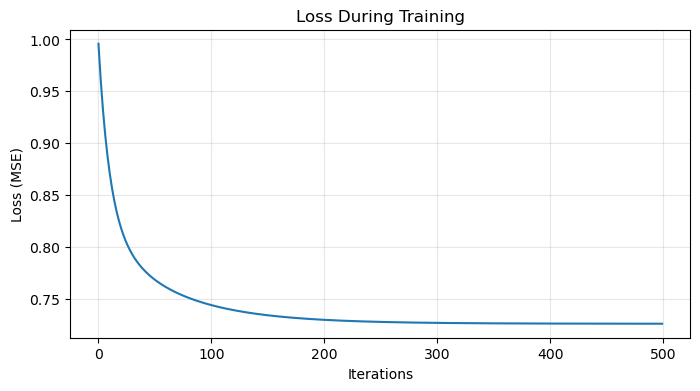

Training MSE: 15.90
Test MSE: 14.69
Training RMSE: 3.99
Test RMSE: 3.83
PREDICTED_FINISH_TIME         : 0.006183
DISTANCE                      : 0.000057
SEX_CLASSIFICATION            : 0.085660
WEIGHT                        : -0.010519


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

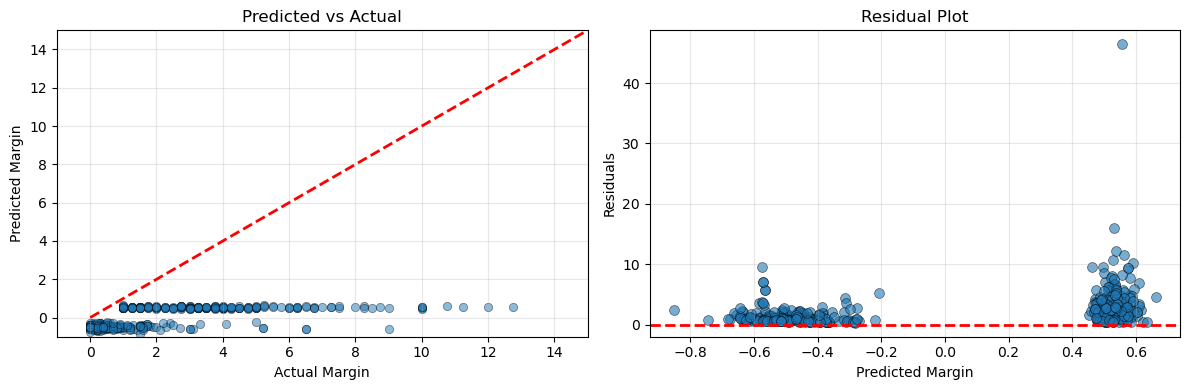

In [29]:
results2 = mini_model_2_multiple_linear_regression(df_combined, results1)

*** need to see if it is possible to have instead actual vs predicted be x and y axis, it should be two separate lines on the same graph

## Main Model: Predicting win/loss probability (Race simulation)